In [1]:
# Load packages

# For the Hermite polynomial basis
using DynamicPolynomials: @polyvar
using MultivariateBases: maxdegree_basis, PhysicistsHermiteBasis, ProbabilistsHermiteBasis

# For finding the centers of the RBF basis
using Clustering

# Some standard linear algebra stuff
using LinearAlgebra
using Trapz  
using ExponentialUtilities

# For visualization
using Printf
using LaTeXStrings
using CairoMakie
dark_latexfonts = merge(theme_black(), theme_latexfonts())
set_theme!(dark_latexfonts)

## System specification

Let's consider the *van der Pol oscillator*
$$ \ddot{x} = \delta (1- x^2) \dot{x} -  x, $$
with $\delta=1$.

Introducing $x_1 = x$ and $x_2 = \dot{x}$, we get
$$ \frac{d}{dt} \begin{pmatrix} x_1 \\ x_2 \end{pmatrix} = \begin{pmatrix} x_2 \\ \delta (1- x_1^2) x_2 -  x_1 \end{pmatrix}. $$

In [2]:
n = 2;           # space dimension

# right-hand side of the Duffing system
function rhs(x)
    δ = 1
    xdot = [x[2]; δ * (1 - x[1]^2) * x[2] - x[1]];
    return xdot
end

# Runge-Kutta integrator to create the time series
function rk4(x0, dt, m, nLag=1)
    x = zeros(n, nLag * m + 1)
    x[:, 1] = x0[:, 1]
    for k = 1 : nLag * m
        k1 = rhs(x[:, k])
        k2 = rhs(x[:, k] + 0.5 * dt * k1)
        k3 = rhs(x[:, k] + 0.5 * dt * k2)
        k4 = rhs(x[:, k] + dt * k3)
        x[:, k + 1] = x[:, k] + dt / 6 * (k1 + 2 * (k2 + k3) + k4)
    end
    return x[:, 1:nLag:end]
end;

## Visualize a couple of trajectories

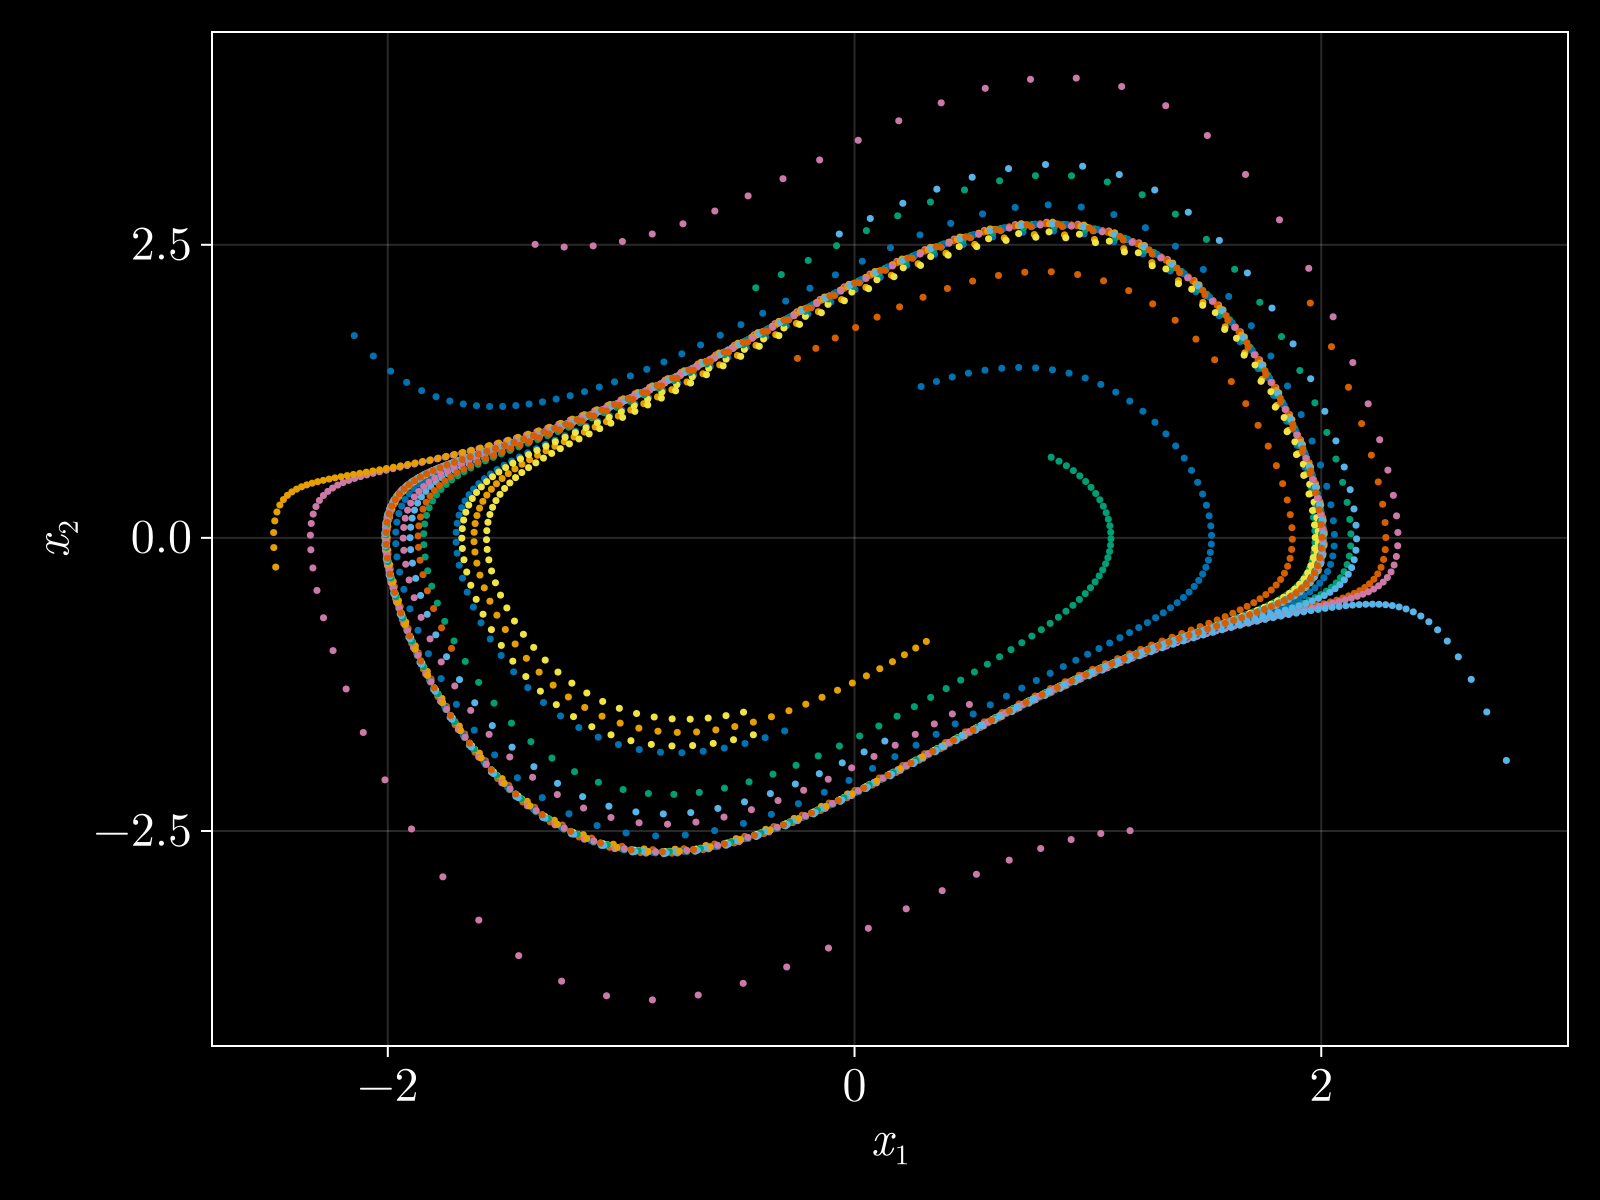

In [3]:
m_traj_vis = 20 # how many trajectories to compute

dt = 0.01       # time step for integrator
nLag_vis = 5    # return out only every 5th entry for the dataset
m_vis = 200     # how many samples per trajectory

x_min = [-3, -3]
x_max = [3, 3]

# simulate trajectories with random initial conditions
X_vis = zeros(n, m_traj_vis * m_vis)
for i in 1 : m_traj_vis
    x0 = x_min .+ (x_max - x_min) .* rand(n,1);
    Xi = rk4(x0, dt, m_vis, nLag_vis);
    X_vis[:, (i-1) * m_vis + 1 : i * m_vis] = Xi[:, 1 : m_vis]
end

# Plotting
fig = Figure(fontsize = 24, size = (800, 600), backgroundcolor = "black")

# trajectories
ax = Axis(fig[1, 1], backgroundcolor = "black", 
    xlabel=L"x_1", ylabel=L"x_2")
for i in 1 : m_traj_vis
    sc = scatter!(ax, X_vis[1, (i-1) * m_vis + 1 : i * m_vis], X_vis[2, (i-1) * m_vis + 1 : i * m_vis], markersize = 5)
end
fig

## Data collection

In [4]:
# same as for the visualization before, 
# but more and shorter trajectories
m_traj = 2000

dt = 0.01
nLag = 25
m = 10

# Y: X mapped forward by one time step of size (dt * nLag)
X = zeros(n, m_traj * m)
Y = zeros(n, m_traj * m)
for i in 1 : m_traj
    x0 = x_min .+ (x_max - x_min) .* rand(n,1);
    Xi = rk4(x0, dt, m, nLag);
    X[:, (i-1) * m + 1 : i * m] = Xi[:, 1 : m]
    Y[:, (i-1) * m + 1 : i * m] = Xi[:, 2 : m + 1]
end

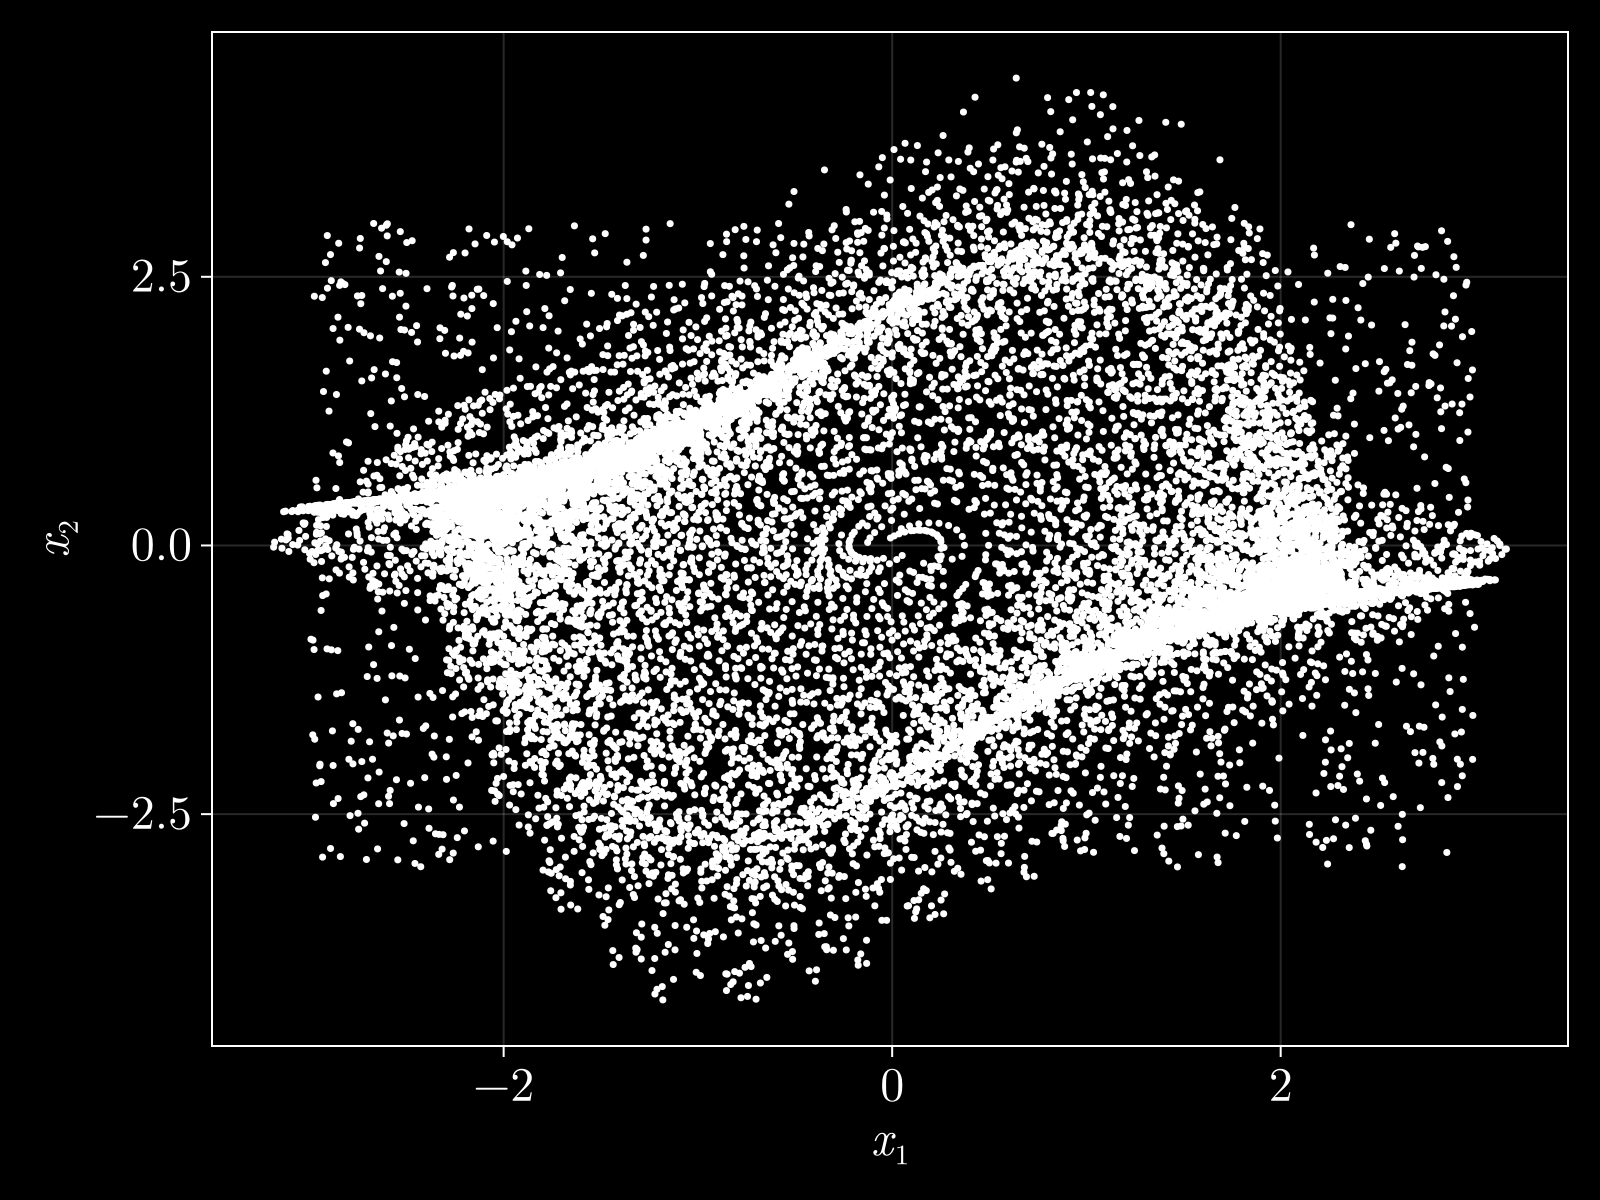

In [5]:
# Visualize the dataset
fig = Figure(fontsize = 24, size = (800, 600), backgroundcolor = "black")
ax = Axis(fig[1, 1], backgroundcolor = "black", 
    xlabel=L"x_1", ylabel=L"x_2")
sc = scatter!(ax, X[1, :], X[2, :], color = :white, markersize = 5)
fig

## Koopman operator

### Set up the dictionary
Hermite polynomials

In [6]:
# this is the code for the Hermite polynomial dictionary

# number if dictionary entries
function getDimPsi(n, max_deg)
    dim_Psi = 1
    for i in 1 : max_deg
        dim_Psi += factorial(n + i - 1) / (factorial(i) * factorial(n - 1))
    end
    return Int(dim_Psi)
end;

# create hermite basis of given degree and n-dimensional inputs
function HermiteBasis(n, max_deg)
    @polyvar pv[1:n]
    basis = maxdegree_basis(ProbabilistsHermiteBasis, pv, max_deg)
    B = reverse(range(2, n + 1))
    return basis, getDimPsi(n, max_deg), B
end;

In [7]:
max_deg = 7;     # maximal degree of hermite basis

# build dictionary function Psi using the basis
function Psi(X)

    n = size(X)[1]
    m = size(X)[2]

    basis, dimPsi, P = HermiteBasis(n, max_deg);

    PsiX = zeros((dimPsi, m))
    for k in 1 : m
        PsiX[:, k] = [b(X[:, k]) for b in basis]
    end
    return PsiX
end;

### EDMD

In [8]:
# Koopman operator approximation via EDMD
ΨX = Psi(X)
ΨY = Psi(Y)
K = inv(ΨX * ΨX') * ΨX * ΨY';

# Projection operator
nPsi = getDimPsi(n, max_deg);
B = zeros((n,nPsi));
B[1, 3] = 1.0;
B[2, 2] = 1.0;

### Generator EDMD
Finite difference approximation of $\dot{\Psi}$ via
- forward differences for first entry of trajectory: $$ \dot{\Psi}(x_1) = \frac{\Psi(x_2) - \Psi(x_1)}{\tau}, $$
- central differences for $2^{\text{nd}}$ to $(m-1)^{\text{st}}$ entry of trajectory: $$ \dot{\Psi}(x_k) = \frac{\Psi(x_{k+1}) - \Psi(x_{k-1})}{2\tau}, \qquad k = 2, \ldots , m-1, $$
- backward differences for last (i.e., $m^\text{th}$) entry of trajectory: $$ \dot{\Psi}(x_m) = \frac{\Psi(x_m) - \Psi(x_{m-1})}{\tau}. $$

In [9]:
ΨXdot = zeros(size(ΨX))

# time step for the discrete-time system
τ = dt * nLag

# loop over all trajectories
for i in 1 : m_traj

    # forward differences for first point in trajectory...
    ΨXdot[:, (i-1) * m + 1] = (ΨX[:, (i-1) * m + 2] - ΨX[:, (i-1) * m + 1]) / τ

    # central differences for points 2 to m-1 ...
    for k in 2 : m - 1
        ΨXdot[:, (i-1) * m + k] = (ΨX[:, (i-1) * m + k + 1] - ΨX[:, (i-1) * m + k - 1]) / (2 * τ)
    end

    # backward differences for last point
    ΨXdot[:, (i-1) * m + m] = (ΨX[:, (i-1) * m + m] - ΨX[:, (i-1) * m + m - 1]) / τ
end

# solve regression problem
L = inv(ΨX * ΨX') * ΨX * ΨXdot';

### Linear system intergrator for the generator equation
$$ \dot{z}(t) = L^\top z(t) $$
Simply using the matrix exponential:
$$ z[k+1] = \exp(L^\top \tau)z[k] $$

In [24]:
Lτ = exponential!(L' * τ);

### Compare the prediction accuracy

In [11]:
# comparison of some trajectories
m_traj_test = 1000
m_test = 20

# create trajectories from random initial conditions
X_test = zeros((n, m_test + 1, m_traj_test))
for i in 1 : m_traj_test
    x0 = x_min .+ (x_max - x_min) .* rand(n,1);
    X_test[:, :, i] = rk4(x0, dt, m_test, nLag);
end

# Test the prediction accuracy via Koopman and generator
ΨX_K_test = zeros((nPsi, m_test + 1, m_traj_test))
XK_test = zeros((n, m_test + 1, m_traj_test))

ΨX_L_test = zeros((nPsi, m_test + 1, m_traj_test))
XL_test = zeros((n, m_test + 1, m_traj_test))

x0 = zeros((2,1))
for i in 1 : m_traj_test
    x0[:, 1] = X_test[:, 1, i]

    # Koopman predictor
    ΨX_K_test[:, 1, i] = Psi(x0)[:, 1]
    for j in 1 : m_test
        ΨX_K_test[:, j + 1, i] = K' * ΨX_K_test[:, j, i]
    end

    # Koopman generator predictor
    ΨX_L_test[:, 1, i] = Psi(x0)[:, 1]
    for j in 1 : m_test
        ΨX_L_test[:, j + 1, i] = Lτ * ΨX_L_test[:, j, i]
    end

    # projection onto the state space
    XK_test[:, :, i] = B * ΨX_K_test[:, :, i]
    XL_test[:, :, i] = B * ΨX_L_test[:, :, i]
end

# calculate RMS
ɛK = zeros((1, m_test + 1))
ɛL = zeros((1, m_test + 1))
for i in 1 : m_traj_test
    ɛK += sqrt.(ones((1,2)) * (XK_test[:, :, i] .- X_test[:, :, i]).^2)
    ɛL += sqrt.(ones((1,2)) * (XL_test[:, :, i] .- X_test[:, :, i]).^2)
end
ɛK /= m_traj_test;
ɛL /= m_traj_test;

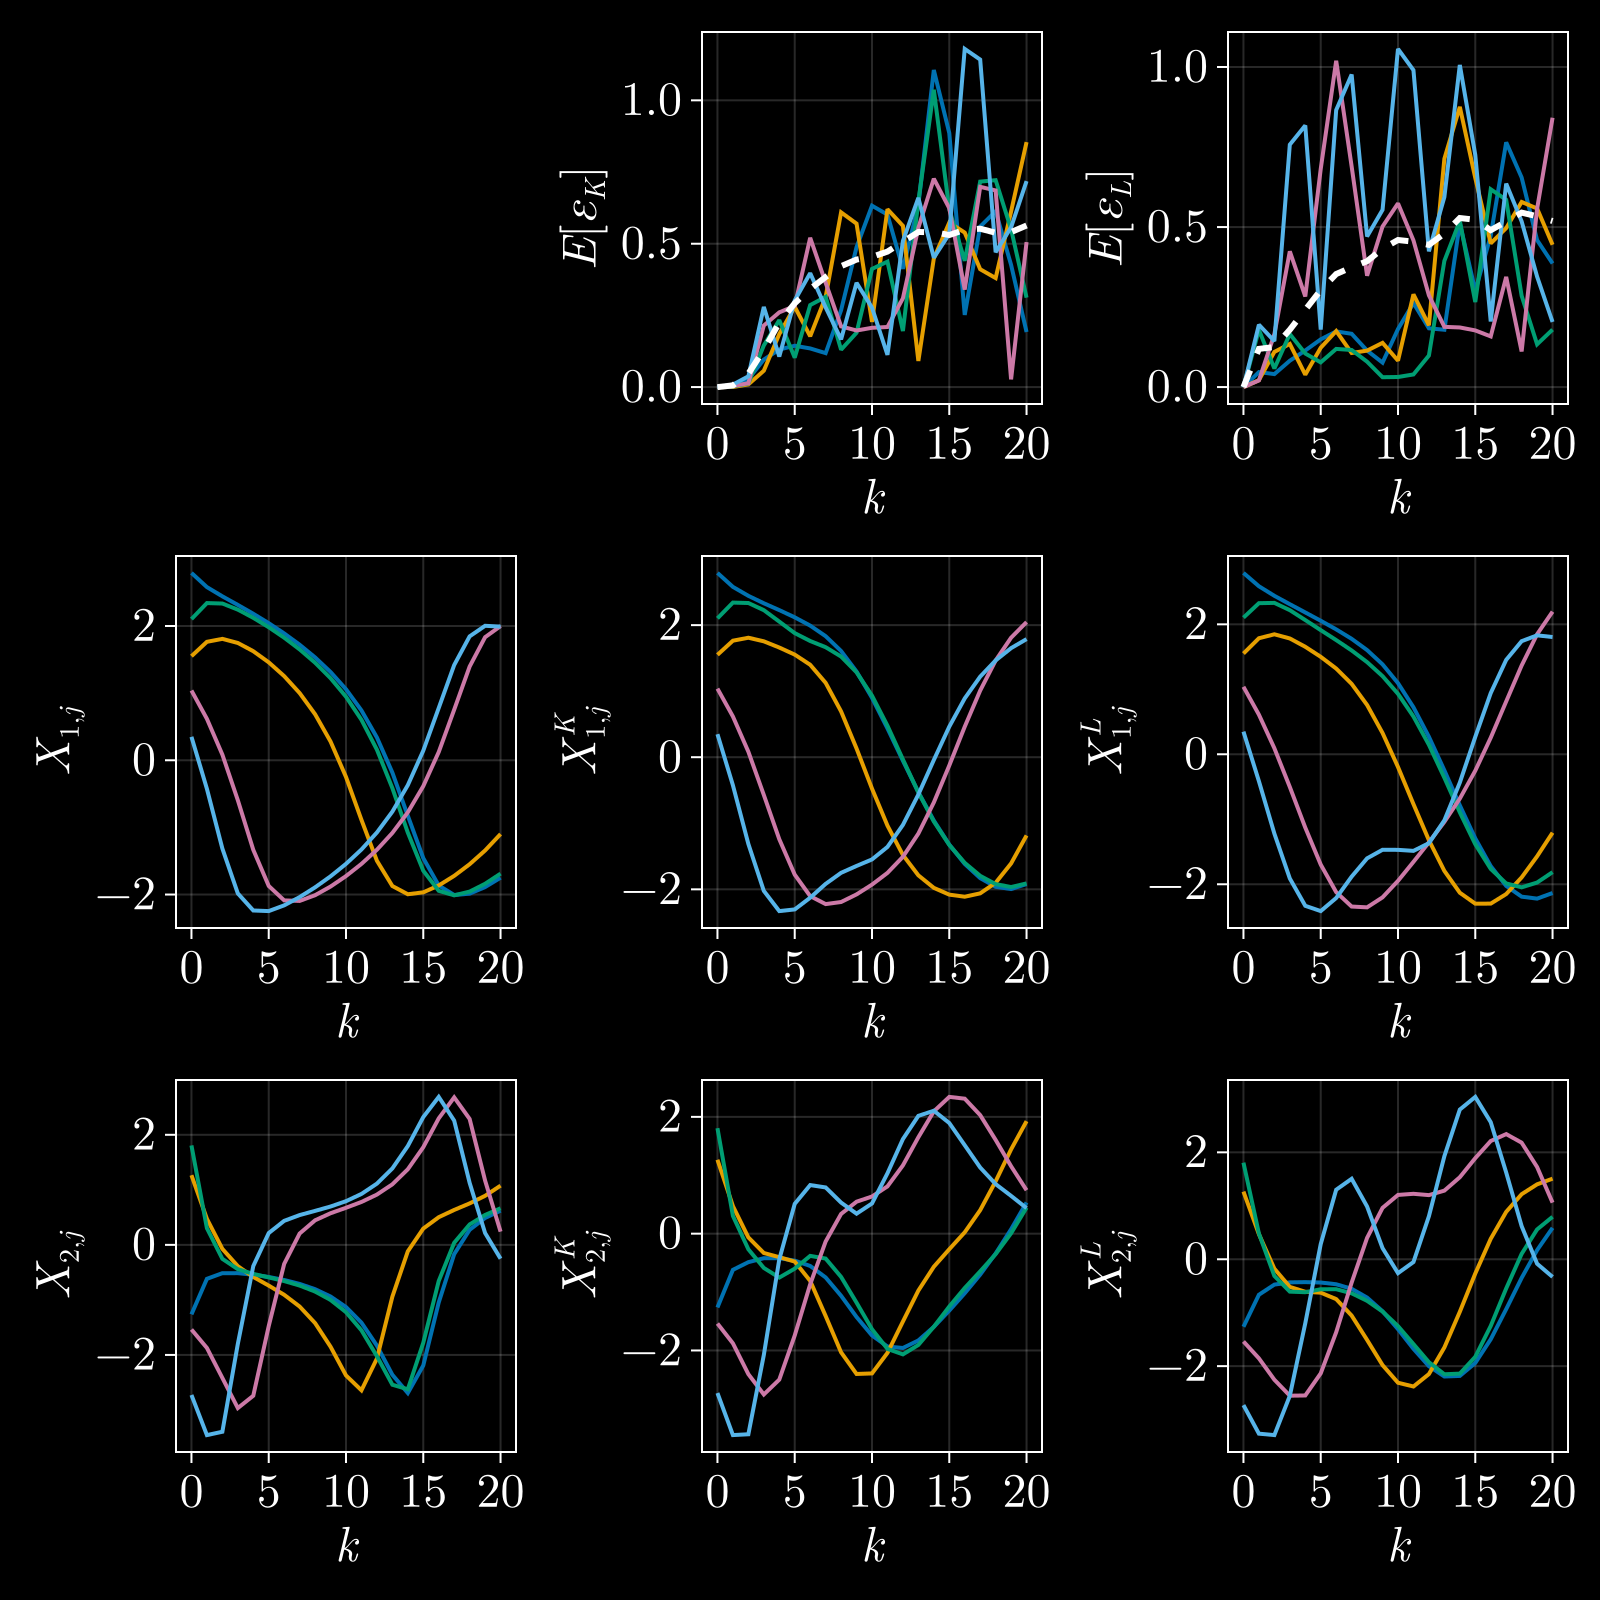

In [14]:
# Plot Error and some trajectories
f = Figure(fontsize = 24, size = (800, 800), backgroundcolor = "black")

ax = Axis(f[1, 2], xlabel = L"k", ylabel = L"E[ɛ_K]")
for i in 1 : 5
    lines!(ax, range(0,m_test), vec(sqrt.(ones((1,2)) * (XK_test[:, :, i] .- X_test[:, :, i]).^2)), linewidth=2)
end
lines!(ax, range(0,m_test), vec(ɛK), color=:white, linewidth=3, linestyle=:dash)

ax = Axis(f[1, 3], xlabel = L"k", ylabel = L"E[ɛ_L]")
for i in 1 : 5
    lines!(ax, range(0,m_test), vec(sqrt.(ones((1,2)) * (XL_test[:, :, i] .- X_test[:, :, i]).^2)), linewidth=2)
end
lines!(ax, range(0,m_test), vec(ɛL), color=:white, linewidth=3, linestyle=:dash)

ax = Axis(f[2, 1], xlabel = L"k", ylabel = L"X_{1,j}")
for i in 1 : 5
    lines!(ax, range(0,m_test), X_test[1,:,i], linewidth=2)
end

ax = Axis(f[2, 2], xlabel = L"k", ylabel = L"X^K_{1,j}")
for i in 1 : 5
    lines!(ax, range(0,m_test), XK_test[1,:,i], linewidth=2)
end

ax = Axis(f[2, 3], xlabel = L"k", ylabel = L"X^L_{1,j}")
for i in 1 : 5
    lines!(ax, range(0,m_test), XL_test[1,:,i], linewidth=2)
end

ax = Axis(f[3, 1], xlabel = L"k", ylabel = L"X_{2,j}")
for i in 1 : 5
    lines!(ax, range(0,m_test), X_test[2,:,i], linewidth=2)
end

ax = Axis(f[3, 2], xlabel = L"k", ylabel = L"X^K_{2,j}")
for i in 1 : 5
    lines!(ax, range(0,m_test), XK_test[2,:,i], linewidth=2)
end

ax = Axis(f[3, 3], xlabel = L"k", ylabel = L"X^L_{2,j}")
for i in 1 : 5
    lines!(ax, range(0,m_test), XL_test[2,:,i], linewidth=2)
end

f

### Compare the spectrum

In [22]:
# Eigendecomposition of K
λ = eigvals(K);
Ξ = eigvecs(K);

# just some sorting
i_sort = reverse(sortperm(real.(λ), by=abs));
λ = λ[i_sort];
Ξ = Ξ[:, i_sort];

# Eigendecomposition of L
μ = eigvals(L);
Μ = eigvecs(L);

# just some sorting
i_sort = reverse(sortperm(real.(μ), by=abs));
μ = μ[i_sort];
Μ = Μ[:, i_sort];

# transfer to discrete-time / continuous-time
λL = exp.(μ .* τ);
μK = log.(λ) ./ τ;

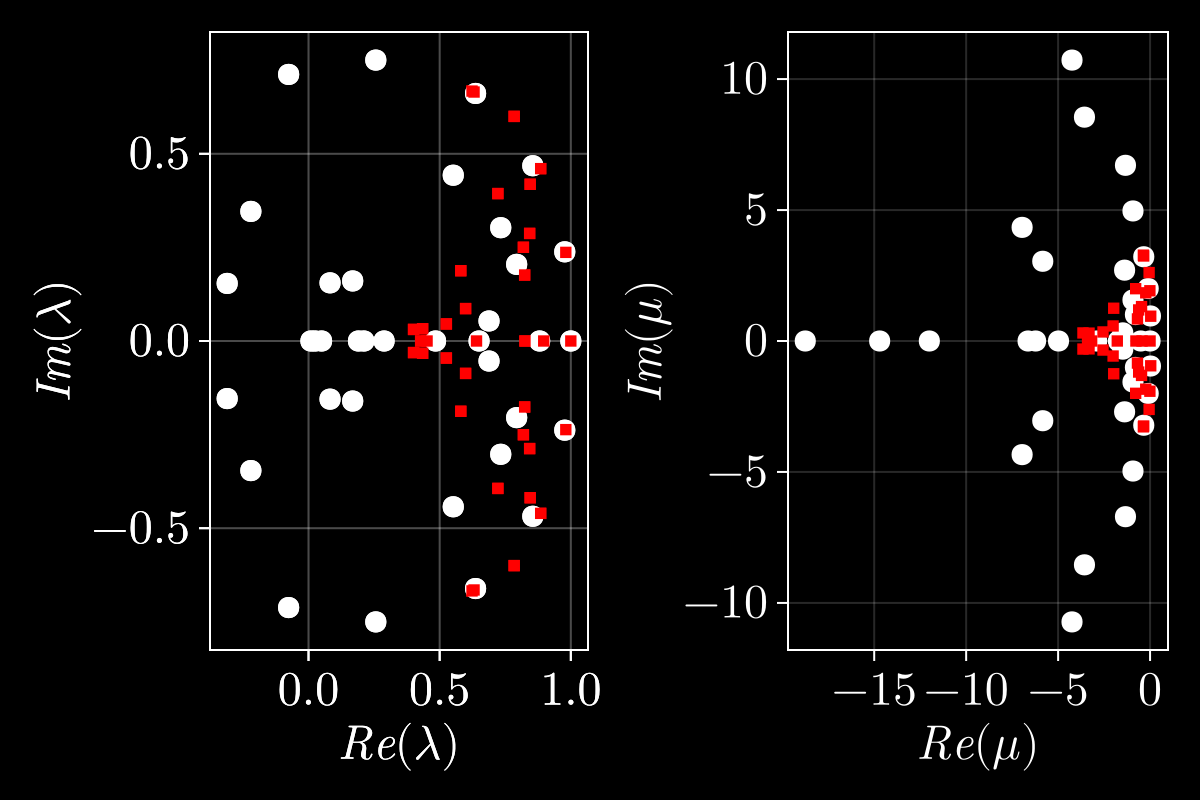

In [23]:
# Visualize the spectrum
f = Figure(fontsize = 24, size = (800, 600), backgroundcolor = "black")

ax = Axis(fig[1, 1], xlabel = L"Re(\lambda)", ylabel = L"Im(\lambda)")
scatter!(ax, real(λ), imag(λ), color="white", markersize=15)
scatter!(ax, real(λL), imag(λL), color="red", marker=:rect)

ax = Axis(fig[1, 2], xlabel = L"Re(\mu)", ylabel = L"Im(\mu)")
scatter!(ax, real(μK), imag(μK), color="white", markersize=15)
scatter!(ax, real(μ), imag(μ), color="red", marker=:rect)

fig